In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from simulai.utilities.lorenz_solver import lorenz_solver, lorenz_solver_forcing
from simulai.utilities.oscillator_solver import oscillator_solver_forcing
from simulai.regression import KoopmanOperator
from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
from simulai.metrics import LyapunovUnits

/home/jalmeida/.conda/envs/appsimulai/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Global parameters.

In [2]:
dt = 0.00025
T_max = 100
rho = 28
beta = 8 / 3
beta_str = '8/3'
sigma = 10
n_field = 3

Generating datasets.

In [3]:
initial_state = np.array([1, 0, 0])[None, :]
lorenz_data, derivative_lorenz_data, time = lorenz_solver(rho=rho, dt=dt, T=T_max, sigma=sigma,
                                                          initial_state=initial_state,
                                                          beta=beta, beta_str=beta_str,
                                                          data_path='on_memory', solver='RK45')

Performing Collocation Derivation.


Hyperparameters and auxiliary parameters.

In [50]:
t = time
lambda_linear = 1e-3
lambda_quadratic = 1e-3
n_steps = time.shape[0]
nt = int(0.8 * n_steps)
nt_test = n_steps - nt
t_test = t[nt:]

Separating train and test datasets.

In [51]:
train_field = lorenz_data[:nt]  # manufactured nonlinear oscillator data
train_field_derivative = derivative_lorenz_data[:nt]

test_field = lorenz_data[nt:]  # manufactured nonlinear oscillator data
test_field_derivatives = derivative_lorenz_data[nt:]

Instantiating and executing Operators Inference with an expanded space of observables. This model consists of a quadratic operator as seen below:

$$
\frac{\mathrm{d}\widehat{\mathbf{u}}}{\mathrm{d}t} = \mathbf{A}\widehat{\mathbf{u}} + \mathbf{H}(\widehat{\mathbf{u}} \otimes \widehat{\mathbf{u}}) + \widehat{\mathbf{c}}
$$
In which $\widehat{\mathbf{u}}$ is a ROM generated from the original space $\mathbf{u}$. In case of Lorenz 63 such intermediary transformation is not necessary, so $\widehat{\mathbf{u}} = \mathbf{u}$.

In [104]:
operator_config = {'bias_rescale':1e-15, 'solver': 'lstsq'}
lorenz_op = KoopmanOperator(observables=['x', 'cos(x)', 'sin(x)'], operator_config=operator_config)

lorenz_op.set(lambda_linear=lambda_linear, lambda_quadratic=lambda_quadratic)
lorenz_op.fit(input_data=train_field, target_data=train_field_derivative)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


In [112]:
print(f"A_hat: {np.array_str(lorenz_op.A_hat, precision=3, suppress_small=True)}")
print(f"H_hat: {np.array_str(lorenz_op.H_hat, precision=3, suppress_small=True)}")
print(f"c_hat: {np.array_str(lorenz_op.c_hat, precision=3, suppress_small=True)}")

A_hat: [[-10.     10.      0.     -0.     -0.     -0.     -0.     -0.     -0.   ]
 [ 28.     -1.      0.     -0.     -0.     -0.     -0.     -0.     -0.   ]
 [  0.     -0.     -2.667   0.      0.      0.      0.      0.      0.   ]]
H_hat: [[ 0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.  0. -0.
   0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.
   0.  0. -0. -0. -0.  0. -0.  0.  0.]
 [ 0. -0. -1.  0.  0.  0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.  0. -0.
   0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.
   0.  0. -0. -0. -0.  0. -0.  0.  0.]
 [-0.  1. -0. -0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.
  -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.
  -0. -0.  0.  0.  0. -0.  0. -0. -0.]]
c_hat: [[-0.]
 [-0.]
 [ 0.]]


In [106]:
init_state = train_field[-1:]
estimated_field_derivatives = lorenz_op.eval(input_data=test_field)
tags = ['x', 'y', 'z']

Visualizing time-derivatives.

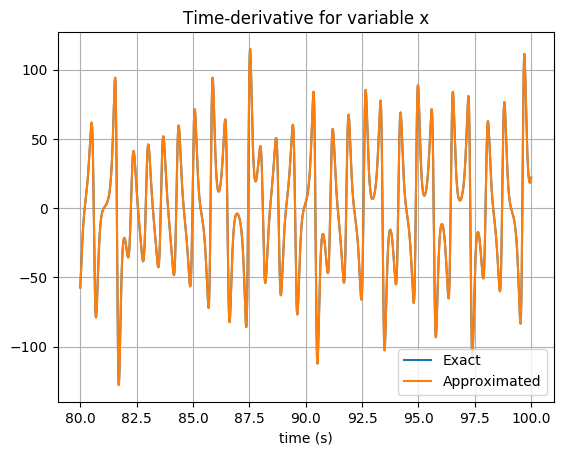

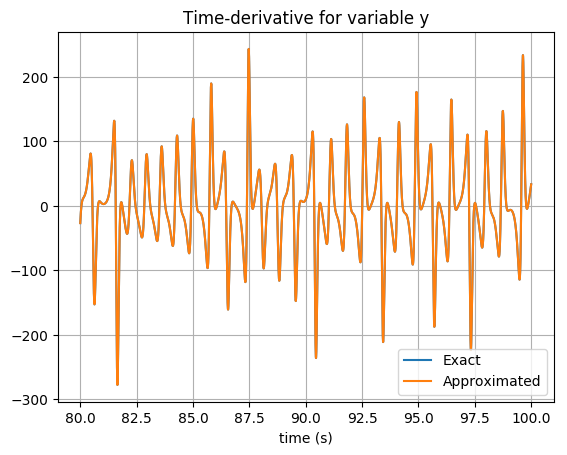

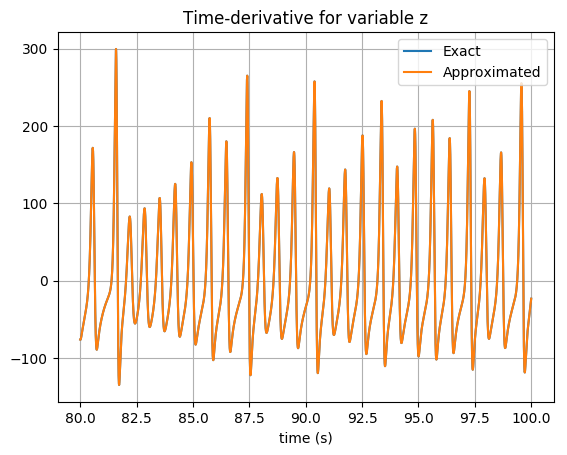

In [107]:
for var in range(n_field):
    plt.title(f"Time-derivative for variable {tags[var]}")
    plt.plot(t_test, test_field_derivatives[:, var], label="Exact")
    plt.plot(t_test, estimated_field_derivatives[:, var], label="Approximated")
    plt.xlabel("time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

Construcing jacobian tensor (It could be used during the time-integrations, but seemingly it is not).

In [108]:
lorenz_op.construct_K_op()

Time-integrating the trained model and visualizing the output.

In [109]:
# Using the derivatives surrogate for time-integrating
right_operator = ClassWrapper(lorenz_op)

solver = LSODA(right_operator)

initial_state = init_state[0]

estimated_field = solver.run(initial_state, t_test)

Estimating the number of Lyapunov units for the extrapolation.

In [110]:
lyapunov_estimator = LyapunovUnits(lyapunov_unit=0.96, tol=0.001, time_scale=dt)
n_units = lyapunov_estimator(data=estimated_field[:], reference_data=test_field, relative_norm=True)
print(f"Number of Lyapunov units extrapolated: {n_units}")

Number of Lyapunov units extrapolated: 13.638541666666667


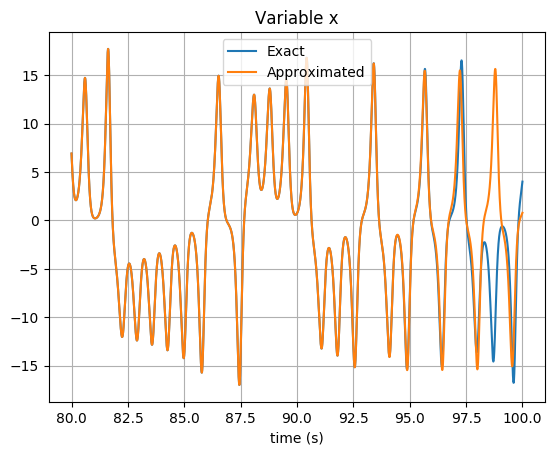

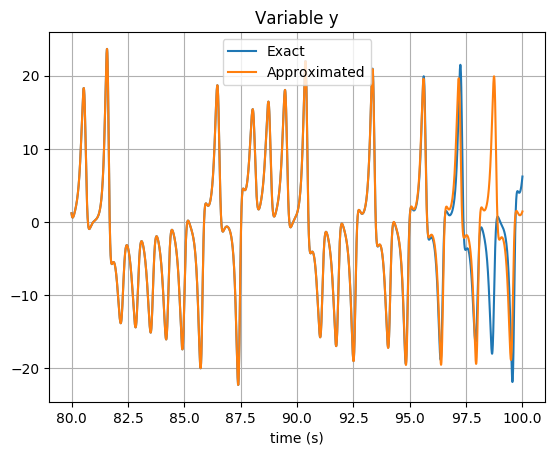

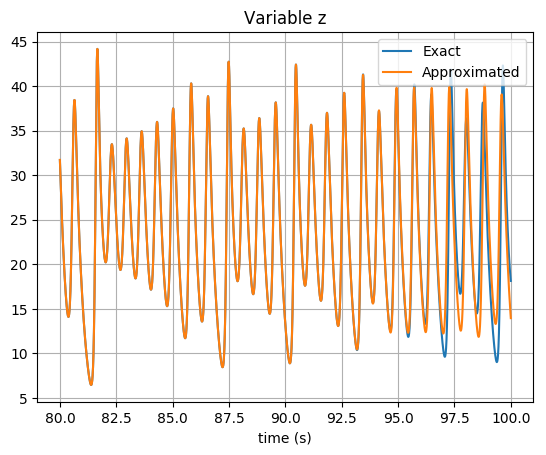

In [111]:
 for var in range(n_field):
    plt.title(f"Variable {tags[var]}")
    plt.plot(t_test, test_field[:, var], label="Exact")
    plt.plot(t_test, estimated_field[:, var], label="Approximated")
    plt.xlabel("time (s)")
    plt.grid(True)
    plt.legend()
    plt.show()